# NN of low-resolution data

Overview
* Load low-res data
* Put back into a spatial format
* Do NN

In [1]:
import glob
import itertools

from scipy import ndimage
from scipy import interpolate
from sklearn import datasets
from sklearn import metrics
from sklearn import base
from sklearn import model_selection
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('mode.chained_assignment', 'raise')

In [6]:
# Load data.
pattern = '../../data/regression/*_data.csv'
paths = glob.glob(pattern)
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# Remove derived and other columns.
cols_to_drop = ['Unnamed: 0', 'cId']
cols_to_drop += [c for c in df.columns if c.endswith('sl')]
cols_to_drop += [c for c in df.columns if c.startswith('lcov_') and c != 'lcov_11']
cols_to_drop += [c for c in df.columns if c.startswith('tr_2013')]
df.drop(cols_to_drop, axis=1, inplace=True)

# Remove zero area rows.
df = df[df.area > 0]

# Convert water land cover to percentage.
df['lcov_11'] = df.lcov_11 / df.area

# Drop rows with water more than 20% of area.
df = df.loc[df.lcov_11 < 0.2]

# Drop nan rows and cols.
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='any')

# Scale elevation by city.
# vars_elev = [i for i in df.columns if 'elev' in i]
# cities = np.unique(df['city'])
# # subtract city median elevation
# medians = df.groupby(df.city)[vars_elev].median().median(axis=1)
# for city in cities:
#     df.loc[df['city']==city,vars_elev] = df.loc[df['city']==city,vars_elev] - medians[city]

# Drop tr vars.
df.drop([c for c in df.columns if c.startswith('tr_')], axis=1, inplace=True)

# Set up test/train
df['target'] = df.lst_day_mean_mean
df.drop([c for c in df.columns if c.startswith('lst_')], axis=1, inplace=True)

In [8]:
df.sample(5).T

,alb_mean_max,alb_mean_mean,alb_mean_min,area,elev_max,elev_mean,elev_min,imp_max,imp_mean,imp_min,lcov_11,ndvi_mean_max,ndvi_mean_mean,ndvi_mean_min,tree_max,tree_mean,tree_min,x,y,target
count,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9.645000e+03,9645.000000,9645.000000
mean,121.503166,76.652833,60.246202,232080.489795,314.283075,301.972660,292.579351,44.102022,31.819320,23.541006,0.002374,0.329298,0.178608,0.064936,44.102022,31.819320,23.541006,1.168313e+06,234850.865608,52.551282
std,48.000275,16.223944,11.898679,51534.905504,176.669785,170.741642,169.575978,21.952495,12.792643,9.270213,0.015768,0.136709,0.098020,0.061038,21.952495,12.792643,9.270213,1.481848e+06,70806.403276,8.280707
min,44.264294,40.303153,33.433277,34.429867,3.364871,1.892370,-6.833117,22.000000,15.055556,11.000000,0.000000,0.033308,0.013991,-0.251508,22.000000,15.055556,11.000000,1.755274e+05,84815.124599,22.440805
25%,89.341408,61.712916,49.807461,250000.000000,184.000000,181.466912,178.000000,24.000000,22.795848,21.000000,0.000000,0.191960,0.106695,0.027671,24.000000,22.795848,21.000000,1.955274e+05,199126.403059,45.626719
50%,108.132957,80.163665,62.946095,250000.000000,332.000000,329.963235,329.000000,43.000000,23.680147,21.000000,0.000000,0.351104,0.135103,0.054499,43.000000,23.680147,21.000000,2.060274e+05,265557.502386,54.728649
75%,141.438751,88.918379,70.017326,250000.000000,447.000000,435.852941,428.000000,52.000000,41.169118,21.000000,0.000000,0.440054,0.246686,0.084635,52.000000,41.169118,21.000000,2.329370e+06,290057.502386,59.568887
max,339.167206,161.087223,98.061729,250000.000000,873.000000,783.838235,702.000000,95.000000,91.904412,90.000000,0.198000,0.616990,0.539130,0.493201,95.000000,91.904412,90.000000,4.119798e+06,323557.502386,65.695301


In [9]:
## Convert each df to its own grid.

# Choose which columns we want as a channel.
feature_cols = [c for c in df.columns if c not in {'city', 'area', 'x', 'y', 'target'}]
feature_cols.sort()
n_channels = len(feature_cols)

city_names = df.city.unique()
city_names.sort()
n_cities = len(city_names)

city_grids = {}
city_targets = {}
city_resolutions = {}

for city in city_names:

    df_city = df[df.city == city].copy()
    x_values = np.sort(df_city.x.unique())
    y_values = np.sort(df_city.y.unique())[::-1]
    n_x = len(x_values)
    n_y = len(y_values)


    # Check maps are of constant density.
    x_deltas = x_values[1:] - x_values[:-1]
    y_deltas = y_values[1:] - y_values[:-1]
    city_resolutions[city] = abs(np.median(x_deltas)), abs(np.median(y_deltas))
    assert np.allclose(x_deltas, np.median(x_deltas))
    assert np.allclose(y_deltas, np.median(y_deltas))

    # Conver to dicts for easy mapping.
    x_indices = {x: i for i, x in enumerate(x_values)}
    y_indices = {y: i for i, y in enumerate(y_values)}
    df_city['x_index'] = df_city.x.map(x_indices)
    df_city['y_index'] = df_city.y.map(y_indices)

    city_grid = np.full([n_y, n_x, n_channels], np.nan)
    city_target = np.full([n_y, n_x, 1], np.nan)

    for row in df_city.itertuples():
        for i_channel, col in enumerate(feature_cols):
            city_grid[row.y_index, row.x_index, i_channel] = getattr(row, col)
            city_target[row.y_index, row.x_index, 0] = row.target
            
    city_grids[city] = (city_grid)
    city_targets[city] = (city_target)

In [13]:
df_city_stats = pd.DataFrame(index=city_names)
df_city_stats['x_resolution'] = [city_resolutions[c][0] for c in city_names]
df_city_stats['y_resolution'] = [city_resolutions[c][1] for c in city_names]
df_city_stats['x_cells'] = [city_targets[c].shape[1] for c in city_names]
df_city_stats['y_cells'] = [city_targets[c].shape[0] for c in city_names]
df_city_stats['data_area'] = [np.isfinite(city_targets[c]).sum() for c in city_names]
df_city_stats['grid_area'] = [np.product(city_targets[c].shape) for c in city_names]

df_city_stats

,x_resolution,y_resolution,x_cells,y_cells,data_area,grid_area
bal,500.0,500.0,32,39,854,1248
det,500.0,500.0,63,44,1540,2772
phx,500.0,500.0,75,140,5776,10500
por,500.0,500.0,57,48,1475,2736


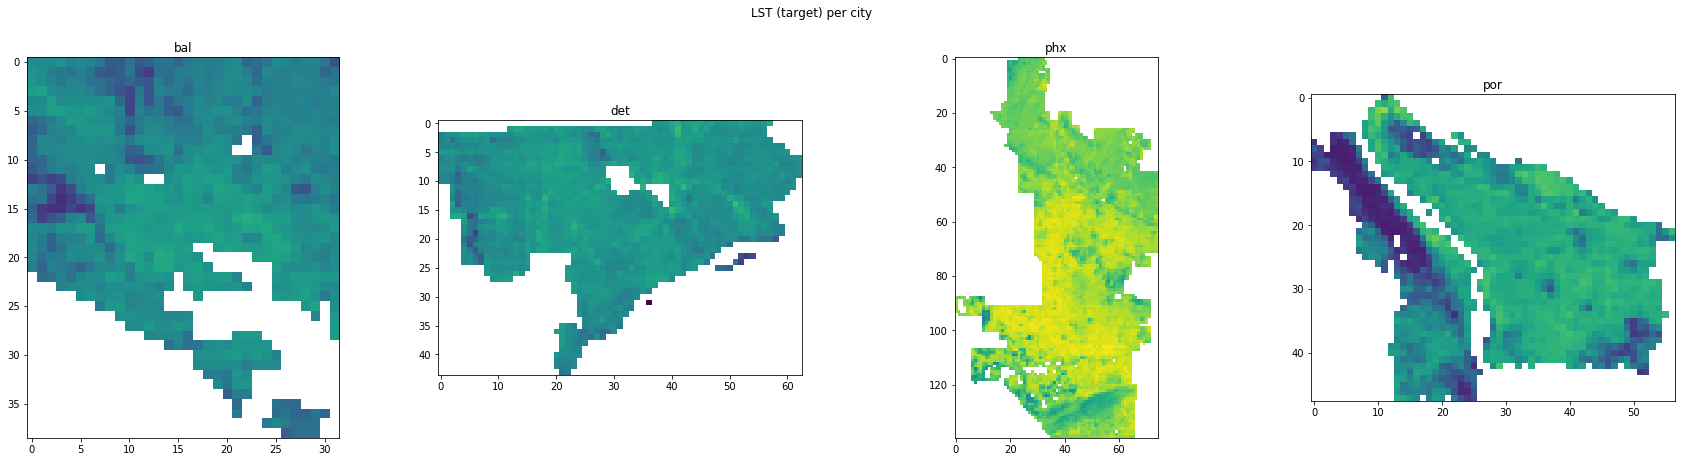

In [14]:
# Plot target.
fig, axes = plt.subplots(1, n_cities, figsize=(30, 7))

vmin = min(a[~np.isnan(a)].min() for a in city_targets.values())
vmax = max(a[~np.isnan(a)].max() for a in city_targets.values())

for ax, city in zip(axes, city_names):
    ax.imshow(city_targets[city][:, :, 0], vmin=vmin, vmax=vmax)
    # ax.imshow(city_targets[city][:, :, 0])
    ax.set_title(city)
    fig.suptitle('LST (target) per city')

In [34]:
city_grid[:,:,0]

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.26900665,
        -0.42291147, -0.45457836],
       [        nan,         nan,         nan, ...,  0.0158989 ,
        -0.73280862, -0.63841684],
       [        nan,         nan,         nan, ..., -0.21048439,
         0.06011915,  0.20273548]])

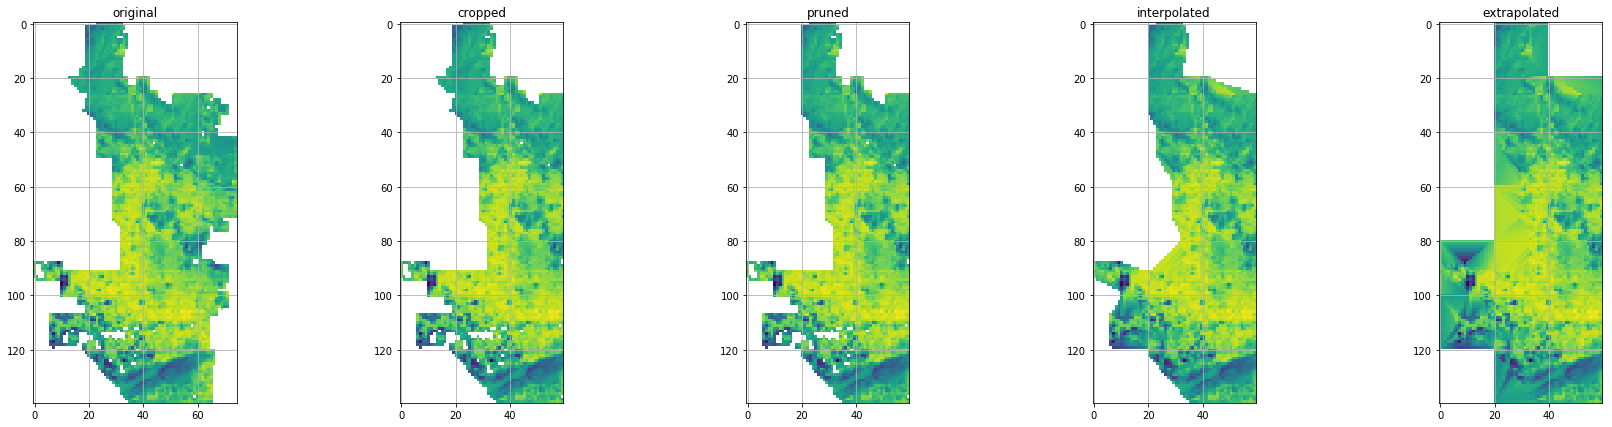

In [15]:
# Data preparation - just phoenix.
city_name = 'phx'
city_grid = city_grids[city_name].copy()
city_target = city_targets[city_name].copy()
city_mask = np.isfinite(city_target)
MAX_NAN_PCT = 0.75

# Normalise data.
class StandardScaler2D(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, *args, **kwargs):
        self.mean = X[np.isfinite(X)].mean()
        self.std = X[np.isfinite(X)].std()
        return self
        
    def transform(self, X, *args, **kwargs):
        return (X - self.mean) / self.std
    
city_target = StandardScaler2D().fit_transform(city_target)
for i in range(n_channels):
    city_grid[:, :, i] = StandardScaler2D().fit_transform(city_grid[:, :, i])

# Show data evolution.
fig, axes = plt.subplots(1, 5, figsize=(30, 7))
vmin = city_target[np.isfinite(city_target)].min()
vmax = city_target[np.isfinite(city_target)].max()

def plot_target(i_axes, title=None):
    axes[i_axes].imshow(city_target[:, :, 0], vmin=vmin, vmax=vmax)
    axes[i_axes].set_title(title)
    axes[i_axes].grid()
    return axes[i_axes]

plot_target(0, 'original')

# Holdout is going to be per-cell. Cells will be square for my sanity. Using the row, col convention here (rather than x,y).
cell_size = 20
n_cells = city_target.shape[0] // cell_size, city_target.shape[1] // cell_size

# Trim data to fit in the cells.
grid_size = n_cells[0] * cell_size, n_cells[1] * cell_size
city_grid = city_grid[:grid_size[0], :grid_size[1], :] 
city_target = city_target[:grid_size[0], :grid_size[1], :]
plot_target(1, 'cropped')


# Prebuild cell coordinates.
cell_coords = {}
for cell_row, cell_col in itertools.product(range(n_cells[0]), range(n_cells[1])):
    rows = slice(cell_row * cell_size, (cell_row + 1) * cell_size)
    cols = slice(cell_col * cell_size, (cell_col + 1) * cell_size)
    cell_coords[cell_row, cell_col] = rows, cols
    
# Remove cells with too little data.
valid_cells = []
for cell, (rows, cols) in cell_coords.items():
    if np.isnan(city_target[rows, cols, 0]).mean() > MAX_NAN_PCT:
        city_target[rows, cols, 0] = np.nan
        city_grid[rows, cols, :] = np.nan
    else:
        valid_cells.append(cell)
valid_coords = {k: v for k, v in cell_coords.items() if k in valid_cells}
plot_target(2, 'pruned')
city_mask_cropped = np.isfinite(city_target)

def interpolate_nan_2d(a):
    x = np.arange(0, a.shape[1])
    y = np.arange(0, a.shape[0])
    a = np.ma.masked_invalid(a)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~a.mask]
    y1 = yy[~a.mask]
    newarr = a[~a.mask]
    return interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy), method='linear')

def extrapolate_nan_2d(a):
    a = a.copy()
    median = np.median(a[np.isfinite(a)])
    for corner in [(0, 0), (0, -1), (-1, 0), (-1, -1)]:
        if np.isnan(a[corner]):
            a[corner] = median
    return interpolate_nan_2d(a)
    
def hash_cell(a):
    return np.round(a.sum(), 2)


# Use linear interpolation to fill in the missing areas. We keep track of the pixels that were filled with dummy data: this will be used to mask the NN later.
masks = {}
for cell, (rows, cols) in valid_coords.items():
    masks[cell] = np.isfinite(city_target[rows, cols, 0])
    city_target[rows, cols, 0] = interpolate_nan_2d(city_target[rows, cols, 0])
    for i_channel in range(n_channels):
        city_grid[rows, cols, i_channel] = interpolate_nan_2d(city_grid[rows, cols, i_channel])
plot_target(3, 'interpolated')

# Finally, extrapolate towards the cell median at the boundaries.
hash_masks = {}
for cell, (rows, cols) in valid_coords.items():
    city_target[rows, cols, 0] = extrapolate_nan_2d(city_target[rows, cols, 0])
    hash_masks[hash_cell(city_target[rows, cols, 0])] = masks[cell]
    for i_channel in range(n_channels):
        city_grid[rows, cols, i_channel] = extrapolate_nan_2d(city_grid[rows, cols, i_channel])
plot_target(4, 'extrapolated')



In [16]:
# NN

# Convert to 4D keras format: (samples, rows, cols, channels).
x_data = np.asarray([city_grid[rows, cols, :] for rows, cols in [valid_coords[c] for c in valid_cells]])
y_data = np.asarray([city_target[rows, cols, :] for rows, cols in [valid_coords[c] for c in valid_cells]])
print(x_data.shape)
print(y_data.shape)

def build_nn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(
        filters=10,
        kernel_size=(7, 7),
        strides=(1, 1),
        activation='relu',
        data_format='channels_last',
        input_shape=x_data[0].shape,
        padding='same',
    ))
    # model.add(keras.layers.MaxPool2D(
    #     pool_size=(2,2)
    # ))
    model.add(keras.layers.Conv2D(
        filters=5,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        data_format='channels_last',
        padding='same',
    ))
    # model.add(keras.layers.UpSampling2D(
    #     size=(2,2),
    #     data_format='channels_last',
    # ))
    model.add(keras.layers.Conv2D(
        filters=1,
        kernel_size=(2, 2),
        strides=(1, 1),
        activation='linear',
        data_format='channels_last',
        padding='same',
    ))
    
    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.Adam(),
    )
    
    return model

for layer in build_nn_model().layers:
    print(layer.name, layer.output_shape)

(15, 20, 20, 16)
(15, 20, 20, 1)
conv2d_1 (None, 20, 20, 10)
conv2d_2 (None, 20, 20, 5)
conv2d_3 (None, 20, 20, 1)


MAE: 0.5442


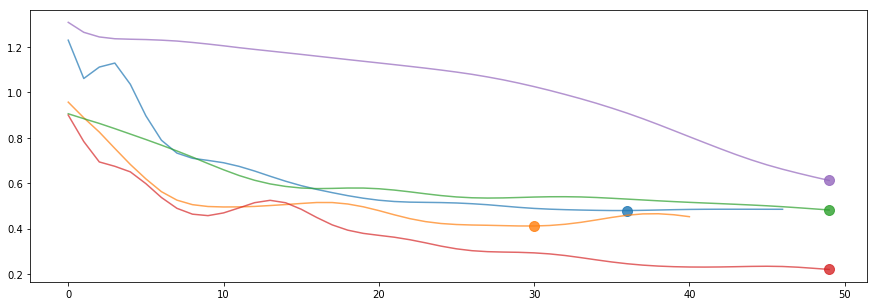

In [17]:
folds = model_selection.KFold(n_splits=5, shuffle=True)
y_oof = np.nan * y_data
histories = []

for idx_train, idx_test in folds.split(x_data):
    x_train = x_data[idx_train]
    x_test = x_data[idx_test]
    y_train = y_data[idx_train]
    y_test = y_data[idx_test]
    
    early_stopping = keras.callbacks.EarlyStopping(patience=10)
    model = build_nn_model()
    history = model.fit(
        x_train, y_train,
#         batch_size=20,
        epochs=50,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping],
    )
    
    histories.append(history)
    y_oof[idx_test] = model.predict(x_test)
    
# Convert OOF back to spatial format.
city_target_oof = city_target.copy()
for indices, vals in zip(valid_cells, y_oof):
    slice_ = cell_coords[indices]
    city_target_oof[slice_] = vals
    
# MAE
mae = metrics.mean_absolute_error(city_target[city_mask_cropped], city_target_oof[city_mask_cropped])
print('MAE: {:.4f}'.format(mae))

# Plot validation loss.
n_histories = len(histories)
fig, ax = plt.subplots(figsize=(15, 5))
for hist in histories:
    val_loss = hist.history['val_loss'] 
    loss = hist.history['loss'] 
    h = ax.plot(val_loss, alpha=0.7)
    arg_min = np.argmin(val_loss)
    ax.plot(arg_min, val_loss[arg_min], '.', color=h[0].get_color(), markersize=20, alpha=0.8)

(140, 75, 1)

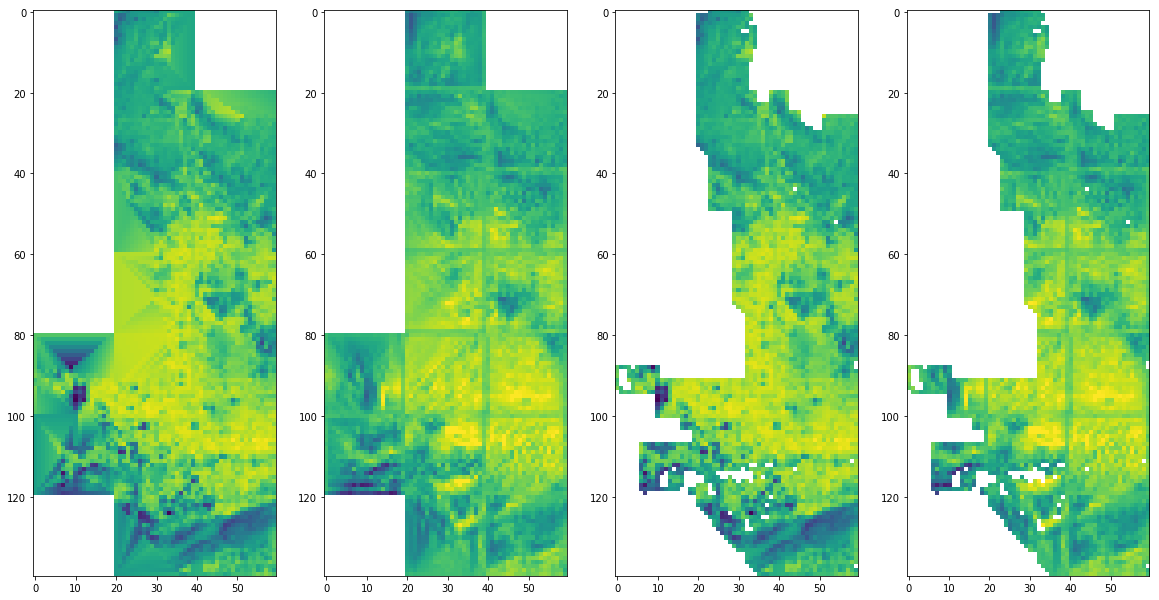

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
vals = city_target.flatten()
vals = np.concatenate([city_target.flatten(), city_target.flatten()])
vals = vals[np.isfinite(vals)]
vmin = min(vals)
vmax = max(vals)

ax = axes[0]
ax.imshow(city_target[:, :, 0], vmin=vmin, vmax=vmax)

ax = axes[1]
ax.imshow(city_target_oof[:, :, 0], vmin=vmin, vmax=vmax)


ax = axes[2]
data = city_target.copy()
data[~city_mask_cropped] = np.nan
ax.imshow(data[:, :, 0], vmin=vmin, vmax=vmax)

ax = axes[3]
data = city_target_oof.copy()
data[~city_mask_cropped] = np.nan
ax.imshow(data[:, :, 0], vmin=vmin, vmax=vmax)

city_mask.shape

In [ ]:
#  Feature importance.

In [ ]:
city_target.shape